In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt 

# Sequential Convex Programming 

Practice problem, nonconvex quadratic program. P symmetric but not PSD: 

\begin{align*}
\text{min } & 0.5x^TPx + q^Tx \\
\text{s.t } & ||x||_{\infty} -1 \leq 0 \\
\end{align*}

1. trust region, solutoin estimate (will need stopping point as iterative)

2. convex approximation of objective and inequality constraints

3. affine apprimation of equality constraints (not required obviously)

4. solve the approximate sub problem

5. the convex approximatoin may also be a subproblem depending on method of approximation
    1. taylor
    2. quasi-linearisatoin
    3. particle method
    
    
I'm just assigning random values for q and P here. 





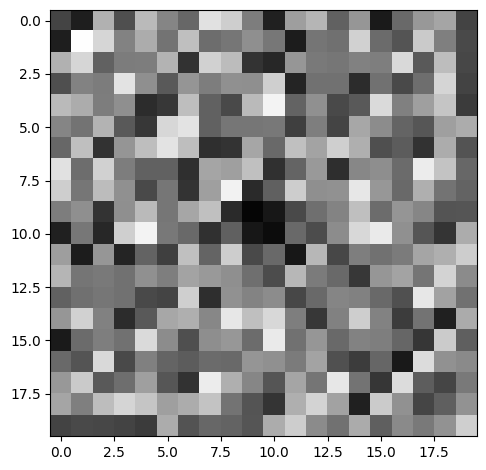

In [11]:
import numpy as np
from skimage import io
n = 20 # size of the matrix
P = np.random.rand(n, n) # generate a random matrix
P = 0.5 * (P + P.T) # make it symmetric
q = np.random.rand(n)
io.imshow(P)

In [139]:


# trust region is going to be a box 
# trust_region = {x | x - x(k) \leq rho_i}
rho = np.ones(n) * 0.1 # lets have this pretty large trust region for now 1/10 problem size

def objective(x):
    return 0.5 * (x.T @ (P @ x)) + q.T @ x

def grad_objective(x):
    '''
    given P is symmeteric, the gradient is just Px + 
    '''
    return P @ x + q 
    
def positive_hessian_objective(): 
    '''
    return the positive part of hessian 
    for this problem hessian is just P, to get positive part of P 
    '''
    eigenvalues, eigenvectors = np.linalg.eig(P)
    D = np.diag(np.maximum(eigenvalues, 0))
    inv_eigenvectors = np.linalg.inv(eigenvectors)
    return eigenvectors @ (D @ inv_eigenvectors) 

def convex_approx_objective(x):
    '''
    can take the convex part of second order taloyr expansion using P_ = psd part of hessian
    
    x : point which is argument to approximate function
    xk : current point 
    '''
    P_ = positive_hessian_objective()
    return objective(x_i) + grad_objective(x_i).T @ (x - x_i) + 0.5 * (x - x_i) @ P_ @ (x - x_i)
    
def constraint(x):
    '''
    infinity norm is max absolute value 
    '''
    return np.max(np.abs(x)) - 1


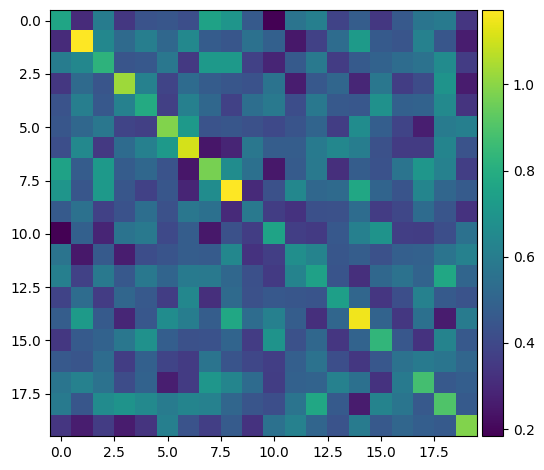

In [142]:
P_ = positive_hessian_objective()
values, vectors = np.linalg.eig(P_)
io.imshow(P_)

## Issue with the constraint. 

It's not immediately obvious to me how to deal with approximating the inequality constraint. The infinity norm isn't differentiable. 

One possiblity which I will try is the particle method where I sample N points in the trust region and evaluate the function there, then fit a function to it, as the approximation. 
Starting with ordinary least squares will use cvxpy if required. 

In [59]:
def least_squares(Z, y):
    return np.linalg.inv(Z.T @ Z) @ Z.T @ y
    

def particle_method_infinty_norm_approximation(x, num_samples=100):
    '''
    sample in trust region, ols linear fit to sample
    
    x @ weights is the approximate function. 
    '''
    Z = np.random.uniform(low=x-(rho/2), high=x+(rho/2), size=(num_samples,n))
    fZ = np.array([constraint(Z_i) for Z_i in Z]) # TODO: no comprehension
    # print(np.sum(fz - objective(z.T))) TODO : how is this diff? 
    weights = least_squares(Z, fZ)
    return weights #  xk @ weights 


<br>
now that I have convex approximation for both functions inside the trust region, can use cvxpy to solve this approximate probelm to find the x(i+1) iterate

In [57]:
import cvxpy  as cp

In [145]:


# random starting point
x_start = np.random.rand(n)
x_i = x_start



# Precomputer variables for approximations 
P_ = positive_hessian_objective() 
print(f'This matrix P_ is symmeteric... {np.allclose(P_, P_.T)}') # so it 
f_x_i = objective(x_i) 
df_x_i = grad_objective(x_i)
constraint_w = particle_method_infinty_norm_approximation(x_i)


# solve the approximate problem 
x = cp.Variable(1)

cp_P = cp.Parameter((n,n))

cp_P.value = P_
# cp_f_x_i.value = f_x_i

#P_ = np.diag(np.ones(n))

cp_df_x_i.value = df_x_i
#cp_w.value = constraint_w 
cp_constraint = [cp.max(cp.abs(x))-1 <= 0, x>=0 ]
#problem = cp.Minimize(cp_f_x_i + cp_df_x_i.T @ (x - cp_x_i) + 0.5*(x - cp_x_i).T @ cp_P @ (x - cp_x_i))

obj = cp.Minimize(f_x_i + df_x_i.T @ (x - x_i) + cp.quad_form((x - x_i), cp_P))
problem = cp.Problem(obj, cp_constraint)
problem.solve(solver=cp.SCS,verbose=True)
x.value 



This matrix P_ is symmeteric... True
(20, 20)
()


ValueError: Quadratic form matrices must be symmetric/Hermitian.